# Table Divider Transformer

This notebook gives examples of the `DITRFormatter`, a new model trained to semantically recognize dividers between cells.

## Downloads

In [37]:
# get the PubTables-1M paper, source of original Table Transformer (TATR)
# !mkdir ./samples
# !wget -O ./samples/tatr.pdf -q https://arxiv.org/pdf/2110.00061
# !wget -O ./samples/attention.pdf -q https://arxiv.org/pdf/1706.03762
# !wget -O ./samples/nmr.pdf -q http://ccc.chem.pitt.edu/wipf/Web/NMR_Impurities.pdf

In [38]:
# !mkdir ./bulk
# !wget -O bulk/1.pdf bulk -q https://link.springer.com/content/pdf/10.1007/s13201-023-02046-6.pdf
# !wget -O bulk/2.pdf bulk -q https://link.springer.com/content/pdf/10.1007/s40268-021-00343-6.pdf
# !wget -O bulk/3.pdf bulk -q https://www.nature.com/articles/s41467-023-38544-z.pdf
# !wget -O bulk/4.pdf bulk -q https://www.nature.com/articles/srep17787.pdf
# !wget -O bulk/5.pdf bulk -q https://journals.iucr.org/m/issues/2019/04/00/ec5013/ec5013.pdf
# !wget -O bulk/6.pdf bulk -q https://thericejournal.springeropen.com/counter/pdf/10.1186/s12284-023-00656-x.pdf
# !wget -O bulk/7.pdf bulk -q https://bmcinfectdis.biomedcentral.com/counter/pdf/10.1186/1471-2334-11-124.pdf
# !wget -O bulk/8.pdf bulk -q https://arxiv.org/pdf/2211.13344
# !wget -O bulk/9.pdf bulk -q https://link.springer.com/content/pdf/10.1007/s00216-012-6627-x.pdf

## Setup

In [39]:
import importlib
import gmft
import gmft.table_detection
import gmft.table_visualization
import gmft.table_function
import gmft.table_function_algorithm
import gmft.table_captioning
import gmft.pdf_bindings
import gmft.pdf_bindings.common
import gmft.common

import gmft.detectors.img2table
import gmft.formatters.ditr

importlib.reload(gmft)
importlib.reload(gmft.common)
importlib.reload(gmft.table_captioning)
importlib.reload(gmft.table_detection)
importlib.reload(gmft.table_visualization)
importlib.reload(gmft.table_function)
importlib.reload(gmft.table_function_algorithm)
importlib.reload(gmft.pdf_bindings)
importlib.reload(gmft.pdf_bindings.common)
importlib.reload(gmft.detectors.img2table)
importlib.reload(gmft.formatters.ditr)

<module 'gmft.formatters.ditr' from 'C:\\conjunct\\gmft\\gmft\\formatters\\ditr.py'>

In [40]:
from gmft.auto import CroppedTable, AutoTableDetector
from gmft.formatters.ditr import DITRFormatConfig, DITRFormatter
from gmft.pdf_bindings import PyPDFium2Document

detector = AutoTableDetector()
formatter = DITRFormatter(DITRFormatConfig(formatter_path="conjuncts/ditr-e15"))

def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for page in doc:
        tables += detector.extract(page)
    return tables, doc


In [41]:
from gmft.table_visualization import display_html_and_image

## tatr, attention, and nmr

In [42]:
import time
import json
_total_detect_time = 0
_total_detect_num = 0
_total_format_time = 0
_total_format_num = 0

results = []
images = []
dfs = []
for paper in ['tatr.pdf', 'attention.pdf', 'nmr.pdf']:
    start = time.time()
    tables, doc = ingest_pdf('./samples/' + paper)
    num_pages = len(doc)
    end_detect = time.time()
    formatted_tables = []
    for i, table in enumerate(tables):
        ft = formatter.extract(table)
        # with open(f'{paper[:-4]}_{i}.info', 'w') as f:
            # f.write(json.dumps(ft.to_dict()))
        try:
            dfs.append(ft.df())
        except Exception as e:
            print(e)
            dfs.append(None)
        formatted_tables.append(ft)
        # cache images, because closing document will prevent image access
        images.append(ft.visualize())
    end_format = time.time()
    doc.close()
    results += formatted_tables
    print(f"Paper: {paper}\nDetect time: {end_detect - start:.3f}s for {num_pages} pages")
    print(f"Format time: {end_format - end_detect:.3f}s for {len(tables)} tables\n")
    _total_detect_time += end_detect - start
    _total_detect_num += num_pages
    _total_format_time += end_format - end_detect
    _total_format_num += len(tables)
print(f"Macro: {_total_detect_time/_total_detect_num:.3f} s/page and {_total_format_time/_total_format_num:.3f} s/table.")
print(f"Total: {(_total_detect_time+_total_format_time)/(_total_detect_num)} s/page")

Paper: tatr.pdf
Detect time: 3.591s for 10 pages
Format time: 3.361s for 6 tables

Paper: attention.pdf
Detect time: 5.762s for 15 pages
Format time: 3.234s for 5 tables

Paper: nmr.pdf
Detect time: 3.067s for 9 pages
Format time: 3.610s for 6 tables

Macro: 0.365 s/page and 0.600 s/table.
Total: 0.6654777246363023 s/page


---

### ./samples/tatr.pdf

,,,,,,

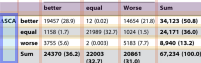

,Dataset,Input Modality,# Tables,Cell Topology,Cell Content,Cell Location,Row & Column Location,Canonical Structure
0,TableBank [9],Image,145K,X,,,,
1,SciTSR [3],PDF∗,15K,X,X,,,
2,"PubTabNet [22, 23]",Image,510K‡,X,X,X†,,
3,FinTabNet [22],PDF∗,113K,X,X,X†,,
4,PubTables-1M (ours),PDF∗,948K,X,X,X,X,X

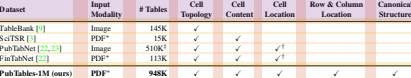

,,
0,,every
1,3:,if the first row starts with a blank cell then add the first row
2,3:,to the column header
3,4:,if there is at least one row labeled as part of the column
4,4:,header then
5,5:,while every column in the column header does not have
6,5:,at least one complete cell that only spans that column do:
7,5:,add the next row to the column header
8,6:,end if
9,7:,for each row do: if the row is not in the column header and

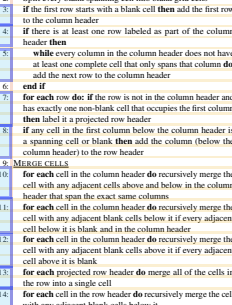

Header 2,NaN,NaN,NaN,Tables with an oversegmented PRH,Tables with an oversegmented PRH,Tables with an oversegmented PRH
Header 1,Dataset,Total Tables \nInvestigated†,Total Tables \nwith a PRH∗,Total,% (of total with a PRH),% (of total investigated)
0,SciTSR PubTabNet FinTabNet,"10,431 422,491 70,028","342 100,159 25,637","54 58,747 25,348",15.79% 58.65% 98.87%,0.52% 13.90% 36.20%
1,PubTables-1M (ours),"761,262","153,705",0,0%,0%

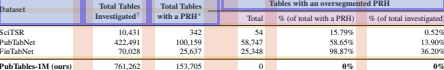

,Task,Model,AP,AP50,AP75,AR
0,TD,Faster R-CNN,0.825,0.985,0.927,0.866
1,TD,DETR,0.966,0.995,0.988,0.981
2,TSR + FA,Faster R-CNN,0.722,0.815,0.785,0.762
3,TSR + FA,DETR,0.912,0.971,0.948,0.942

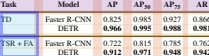

,Test Data,Model,Table Category,AccCont,GriTSTop,GriTSCont,GriTSLoc,AdjCont
0,Non-Canonical,DETR-NC,Simple,0.8678,0.9872,0.9859,0.9821,0.9801
1,Non-Canonical,DETR-NC,Complex,0.5360,0.9600,0.9618,0.9444,0.9505
2,Non-Canonical,DETR-NC,All,0.7336,0.9762,0.9761,0.9668,0.9681
3,Canonical,DETR-NC,Simple,0.9349,0.9933,0.9920,0.9900,0.9865
4,Canonical,DETR-NC,Complex,0.2712,0.9257,0.9290,0.9044,0.9162
5,Canonical,DETR-NC,All,0.5851,0.9576,0.9588,0.9449,0.9494
6,Canonical,Faster R-CNN,Simple,0.0867,0.8682,0.8571,0.6869,0.8024
7,Canonical,Faster R-CNN,Complex,0.1193,0.8556,0.8507,0.7518,0.7734
8,Canonical,Faster R-CNN,All,0.1039,0.8616,0.8538,0.7211,0.7871
9,Canonical,DETR,Simple,0.9468,0.9949,0.9938,0.9922,0.9893

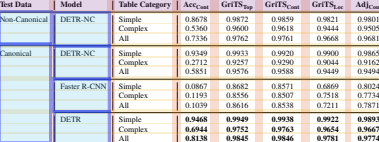

---

### ./samples/attention.pdf

,,,,,
0,Ashish Vaswani∗ Google Brain avaswani@google.com,Noam Shazeer∗ Google Brain noam@google.com,Niki Google,Parmar∗ Research nikip@google.com,Jakob Uszkoreit∗ Google Research usz@google.com
1,Llion Jones∗,Aidan N. Gomez∗,†,Łukasz,Kaiser∗
2,Google Research,University of Toronto aidan@cs.toronto.edu,,Google,Brain
3,llion@google.com,University of Toronto aidan@cs.toronto.edu,‡,,lukaszkaiser@google.com
4,,Illia Polosukhin∗ illia.polosukhin@gmail.com,,,
5,,Abstract,,,
6,"The dominant sequence convolutional neural performing models mechanism. We based solely on attention entirely. Experiments be superior in quality less time to train. translation ensembles, by over 2 our model establishes training for 3.5 days best models from the other tasks by applying large and limited","transduction models networks that include also connect the encoder propose a new simple mechanisms, dispensing on two machine while being more Our model achieves 28.4 English￾to-German task, improving over BLEU. On the WMT a new single-model on eight GPUs, a small literature. We show that it successfully to training data.",are an encoder and network with translation parallelizable BLEU the 2014 state-of-the-art fraction the English,"based on complex and a decoder. decoder through architecture, the recurrence and tasks show these and requiring on the WMT existing best results, English-to-French BLEU score of the training Transformer generalizes constituency parsing","recurrent or The best an attention Transformer, convolutions models to significantly 2014 including translation task, of 41.8 after costs of the well to both with"

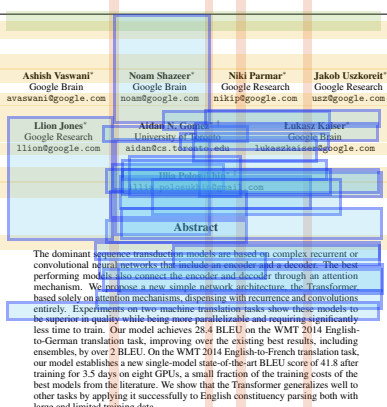

,Layer Type,Complexity per Layer,Sequential Operations,Maximum Path Length
0,Self-Attention,O(n 2 · d),O(1),O(1)
1,Recurrent,O(n · d 2 ),O(n),O(n)
2,Convolutional,O(k · n · d 2 ),O(1),O(logk(n))
3,Self-Attention (restricted),O(r · n · d),O(1),O(n/r)

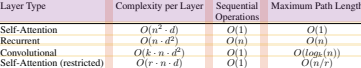

Header 2,NaN,BLEU,BLEU,Training Cost (FLOPs),Training Cost (FLOPs)
Header 1,Model,EN-DE,EN-FR,EN-DE,EN-FR
0,ByteNet [18],23.75,,,
1,Deep-Att + PosUnk [39],,39.2,,1.0 · 1020
2,GNMT + RL [38],24.6,39.92,2.3 · 1019,1.4 · 1020
3,ConvS2S [9],25.16,40.46,9.6 · 1018,1.5 · 1020
4,MoE [32],26.03,40.56,2.0 · 1019,1.2 · 1020
5,Deep-Att + PosUnk Ensemble [39] GNMT + RL Ensemble [38] ConvS2S Ensemble [9],26.30 26.36,40.4 41.16 41.29,1.8 · 1020 7.7 · 1019,8.0 · 1020 1.1 · 1021 1.2 · 1021
6,Transformer (base model) Transformer (big),27.3 28.4,38.1 41.8,3.3 · 2.3 ·,1018 1019

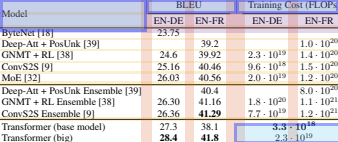

,,N,dmodel,dff,h,dk,dv,Pdrop,ϵls,train steps,PPL (dev),BLEU (dev),params ×106
0,base,6,512,2048,8,64,64,0.1,0.1,100K,4.92,25.8,65
1,(A),,,,1,512,512,,,,5.29,24.9,
2,(A),,,,4,128,128,,,,5.00,25.5,
3,(A),,,,16,32,32,,,,4.91,25.8,
4,(A),,,,32,16,16,,,,5.01,25.4,
5,(B),,,,,16 32,,,,,5.16 5.01,25.1 25.4,58 60
6,,2,,,,,,,,,6.11,23.7,36
7,,4,,,,,,,,,5.19,25.3,50
8,,8,,,,,,,,,4.88,25.5,80
9,(C),,256,,,32,32,,,,5.75,24.5,28

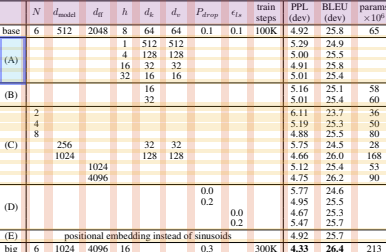

,Parser,Training,WSJ 23 F1
0,Vinyals & Kaiser el al. (2014) [37] Petrov et al. (2006) [29] Zhu et al. (2013) [40] Dyer et al. (2016) [8],"WSJ only, discriminative WSJ only, discriminative WSJ only, discriminative WSJ only, discriminative",88.3 90.4 90.4 91.7
1,Transformer (4 layers) Zhu et al. (2013) [40],"WSJ only, discriminative semi-supervised",91.3 91.3
2,Huang & Harper (2009) [14],semi-supervised,91.3
3,McClosky et al. (2006) [26] Vinyals & Kaiser el al. (2014) [37],semi-supervised semi-supervised,92.1 92.1
4,Transformer (4 layers) Luong et al. (2015) [23] Dyer et al. (2016) [8],semi-supervised multi-task generative,92.7 93.0 93.3

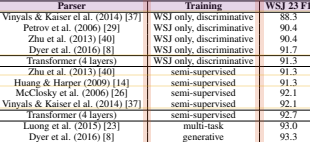

---

### ./samples/nmr.pdf

,
0,"C6D5H in C6D6. E xcept for CHCl3, the splitting due to J HD is t ypically"
1,"obser ved (t o a good a ppr oxim ation, it is 1/6.5 of t h e valu e of t"
2,"r espon din g J HH). F or CHD2 gr ou ps (deut er at ed a cet on e, DMSO,"
3,"cet onit rile), t his sign al is a 1:2:3:2:1 quint et wit h a splittin g of ca."


,,pr ot,on,m ult,CDCl3,(CD3)2CO,(CD3)2SO,C6D6,CD3CN,CD3OD,D2O
0,solvent r esidu al pea k,,,,7.26,2.05,2.50,7.16,1.94,3.31,4.79
1,H2O,,,s,1.56,2.84a,3.33a,0.40,2.13,4.87,
2,a cetic a cid,CH3,,s,2.10,1.96,1.91,1.55,1.96,1.99,2.08
3,a cet on e,CH3,,s,2.17,2.09,2.09,1.55,2.08,2.15,2.22
4,a cet onit rile,CH3,,s,2.10,2.05,2.07,1.55,1.96,2.03,2.06
5,benzene,CH,,s,7.36,7.36,7.37,7.15,7.37,7.33,
6,tert-but yl alcoh ol,CH3,,s,1.28,1.18,1.11,1.05,1.16,1.40,1.24
7,tert-but yl alcoh ol,OHc,,s,,,4.19,1.55,2.18,,
8,tert-but yl m et h yl et h,CCH3,,s,1.19,1.13,1.11,1.07,1.14,1.15,1.21
9,er,OCH3,,,3.22,3.13,3.08,3.04,3.13,3.20,3.22

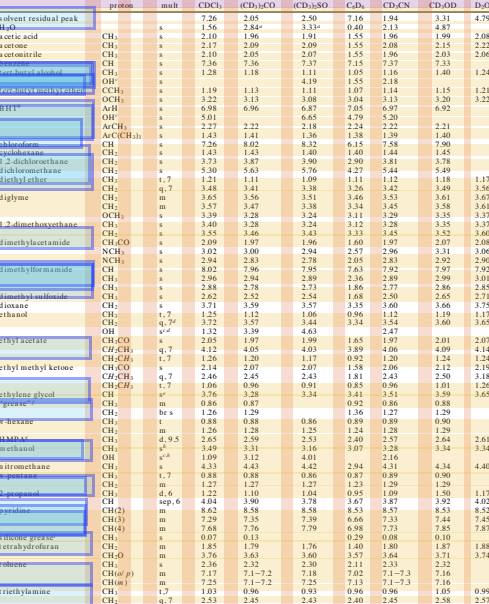

,CDCl3 (CD3)2CO (CD3)2SO C6D6 CD3CN CD3OD,CDCl3 (CD3)2CO (CD3)2SO C6D6 CD3CN CD3OD,CDCl3 (CD3)2CO (CD3)2SO C6D6 CD3CN CD3OD,CDCl3 (CD3)2CO (CD3)2SO C6D6 CD3CN CD3OD,CDCl3 (CD3)2CO (CD3)2SO C6D6 CD3CN CD3OD,CDCl3 (CD3)2CO (CD3)2SO C6D6 CD3CN CD3OD,CDCl3 (CD3)2CO (CD3)2SO C6D6 CD3CN CD3OD,CDCl3 (CD3)2CO (CD3)2SO C6D6 CD3CN CD3OD,CDCl3 (CD3)2CO (CD3)2SO C6D6 CD3CN CD3OD,CDCl3 (CD3)2CO (CD3)2SO C6D6 CD3CN CD3OD,D2O
0,solvent sign als,,77.16 ( 0.06,,29.84 ( 0.01 206.26 ( 0.13,,39.52 ( 0.06,128.06 ( 0.02,1.32 ( 0.02 118.26 ( 0.02,49.00(0.01,
1,a cetic a cid,CO,175.99,,172.31,,171.93,175.82,173.21,175.11,177.21
2,,CH3,20.81,,20.51,,20.95,20.37,20.73,20.56,21.03
3,a cet on e,CO CH3,207.07 30.92,,205.87 30.60,,206.31 30.56,204.43 30.14,207.43 30.91,209.67 30.67,215.94 30.89
4,a cet onit rile,CN,116.43,,117.60,,117.91,116.02,118.26,118.06,119.68
5,benzene,CH3 CH,1.89 128.37,,1.12 129.15,,1.03 128.30,0.20 128.62,1.79 129.32,0.85 129.34,1.47
6,tert-but yl alcoh ol,C,69.15,,68.13,,66.88,68.19,68.74,69.40,70.36
7,tert-but yl m et h yl et h er,CH3 OCH3,31.25 49.45,,30.72 49.35,,30.38 48.70,30.47 49.19,30.68 49.52,30.91 49.66,30.29 49.37
8,tert-but yl m et h yl et h er,C,72.87,,72.81,,72.04,72.40,73.17,74.32,75.62
9,BHT,CCH3 C(1),26.99 151.55,,27.24 152.51,,26.79 151.47,27.09 152.05,27.28 152.42,27.22 152.85,26.60

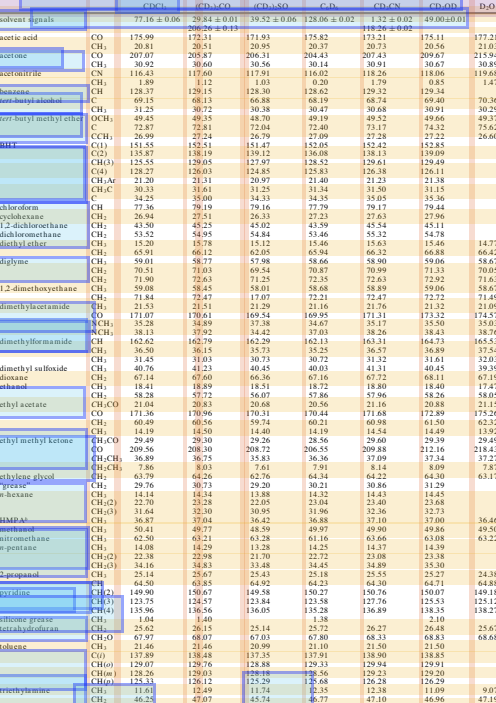

,,proton,,mult,THF-d8,CD2Cl2,CDCl3,toluene-d8,C6D6,C6D5Cl,(CD3)2CO (CD3)2SO CD3CN,(CD3)2CO (CD3)2SO CD3CN,(CD3)2CO (CD3)2SO CD3CN,(CD3)2CO (CD3)2SO CD3CN,TFE-d3,CD3OD,D2O
0,solvent residual,,,,1.72,5.32,7.26,2.08,7.16,6.96,2.05,,,2.50 1.94,5.02,3.31,4.79
1,signals,,,,3.58,,,6.97,,6.99,,,,,3.88,,
2,,,,,,,,7.01 7.09,,7.14,,,,,,,
3,water acetic acid,OH CH3,,s s,2.46 1.89,1.52 2.06,1.56 2.10,0.43 1.57,0.40 1.52,1.03 1.76,2.84b 1.96,,,3.33b 2.13 1.91 1.96,3.66 2.06,4.87 1.99,2.08
4,acetone,CH3,,s,2.05,2.12,2.17,1.57,1.55,1.77,2.09,,,2.09 2.08,2.19,2.15,2.22
5,acetonitrile,CH3,,s,1.95,1.97,2.10,0.69,0.58,1.21,2.05,,,2.07 1.96,1.95,2.03,2.06
6,benzene,CH,,s,7.31,7.35,7.36,7.12,7.15,7.20,7.36,,,7.37 7.37,7.36,7.33,
7,tert -butyl alcohol,CH3 OH,,s sc,1.15 3.16,1.24,1.28,1.03 0.58,1.05 0.63,1.12 1.30,1.18,,,1.11 1.16 4.19 2.18,1.28 2.20,1.40,1.24
8,chloroform 18-crown-6,CH CH2,,s s,7.89 3.57,7.32 3.59,7.26 3.67,6.10 3.36,6.15 3.39,6.74 3.41,8.02 3.59,,,8.32 7.58 3.51 3.51,7.33 3.64,7.90 3.64,3.80
9,"cyclohexane 1,2-dichloroethane",CH2 CH2,,s s,1.44 3.77,1.44 3.76,1.43 3.73,1.40 2.91,1.40 2.90,1.37 3.26,1.43 3.87,,,1.40 1.44 3.90 3.81,1.47 3.71,1.45 3.78,

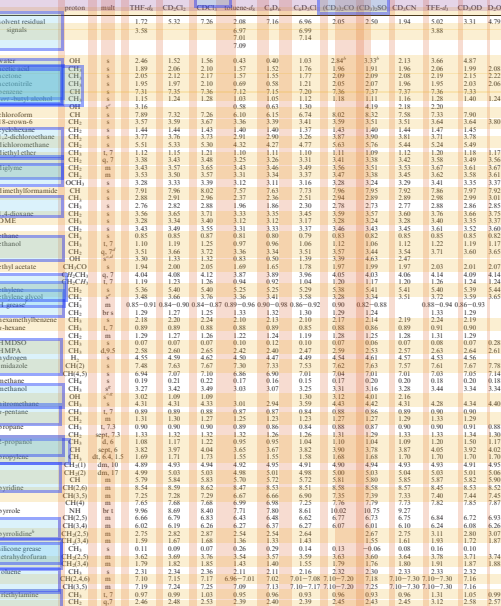

,,carbon,THF-d8,CD2Cl2,CDCl3,toluene- d8 C6D6 C6D5Cl (CD3)2CO,(CD3)2SO,CD3CN,TFE-d3,CD3OD,D2O
0,solvent signals,,67.21 25.31,53.84,77.16,137.48 128.06 134.19 29.84 128.87 129.26 206.26 127.96 128.25,39.52,1.32 118.26,61.50 126.28,49.00,
1,solvent signals,,,,,125.13 125.96 20.43,,,,,
2,acetic acid,CO,171.69,175.85,175.99,175.30 175.82 175.67 172.31,171.93,173.21,177.96,175.11,177.21
3,acetone,CH3 CO CH3,20.13 204.19 30.17,20.91 206.78 31.00,20.81 207.07 30.92,20.27 20.37 20.40 20.51 204.00 204.43 204.83 205.87 30.03 30.14 30.12 30.60,20.95 206.31 30.56,20.73 207.43 30.91,20.91 32.35 214.98,20.56 209.67 30.67,21.03 215.94 30.89
4,acetonitrile,CN CH3,116.79 0.45,116.92 2.03,116.43 1.89,115.76 116.02 115.93 117.60 0.03 0.20 0.63 1.12,117.91 1.03,118.26 1.79,118.95 1.00,118.06 0.85,119.68 1.47
5,benzene,CH,128.84,128.68,128.37,128.57 128.62 128.38 129.15,128.30,129.32,129.84,129.34,
6,tert -butyl alcohol,(CH3)3C (CH3)3C,67.50 30.57,69.11 31.46,69.15 31.25,68.12 68.19 68.19 68.13 30.49 30.47 31.13 30.72,66.88 30.38,68.74 30.68,72.35 31.07,69.40 30.91,70.36 30.29
7,carbon dioxide,CO2,125.69,125.26,124.99,124.86 124.76 126.08 125.81,124.21,125.89,126.92,126.31,
8,carbon disulfide carbon tetrachloride chloroform,CS2 CCl4 CH,193.37 96.89 79.24,192.95 96.52 77.99,192.83 96.34 77.36,192.71 192.69 192.49 193.58 96.57 96.44 96.38 96.65 77.89 77.79 77.67 79.19,192.63 95.44 79.16,193.60 96.68 79.17,196.26 97.74 78.83,193.82 97.21 79.44,197.25 96.73
9,18-crown-6 cyclohexane,CH2 CH2,71.34 27.58,70.47 27.38,70.55 26.94,70.86 70.59 70.55 71.25 27.31 27.23 26.99 27.51,69.85 26.33,71.22 27.63,70.80 28.34,71.47 27.96,70.14

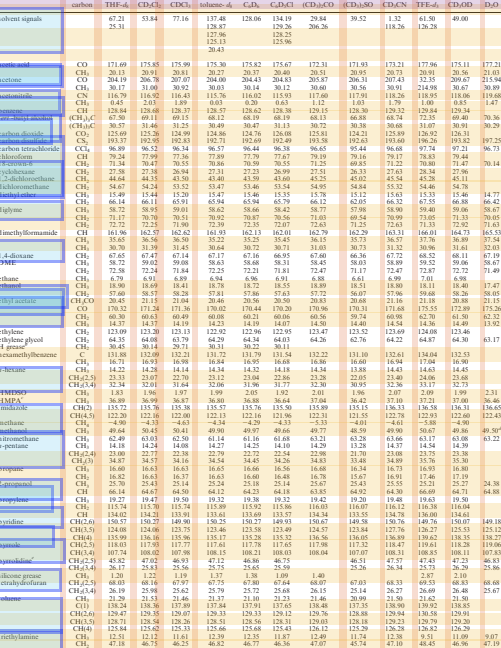

,
0,grateful.

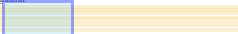

In [43]:
from IPython.display import display, Markdown
import pandas as pd

prev_doc = None
for df, img, ft in zip(dfs, images, results):
    with pd.option_context('display.max_rows', 500, "display.multi_sparse", False):
        if ft.page.filename != prev_doc:
            prev_doc = ft.page.filename
            display(Markdown('---'))
            display(Markdown(f'### {ft.page.filename}'))
            
        if df is not None:
            html = df.fillna("").to_html()
        else:
            html = "Failed to extract table"
        display_html_and_image(html, img)
        


## Bulk pdfs

- 1.pdf - 10.1007/s13201-023-02046-6 - no pmcid - not in train
- 2.pdf - 10.1007/s40268-021-00343-6 - pmc8206310 - not in train
- 3.pdf - 10.1038/s41467-023-38544-z - pmc10198988 - not in train
- 4.pdf - 10.1038/srep17787 - pmc4671006 - not in train set
- 5.pdf - 10.1107/s2052252519008285 - pmc6608623 - not in train
- 6.pdf - 10.1186/s12284-023-00656-x - no pmcid - not in train
- 7.pdf - 10.1186/1471-2334-11-124 - pmc3112098 - **IS in train set**
- 8.pdf - 10.48550/arXiv.2211.13344 - no pmcid - not in train
- 9.pdf - 10.1007/s00216-012-6627-x - pmc3608873 - not in train

In [44]:
import time
import json
import os
_total_detect_time = 0
_total_detect_num = 0
_total_format_time = 0
_total_format_num = 0

results = []
images = []
dfs = []
for paper in os.listdir('./bulk'):
    start = time.time()
    tables, doc = ingest_pdf('./bulk/' + paper)
    num_pages = len(doc)
    end_detect = time.time()
    formatted_tables = []
    for i, table in enumerate(tables):
        ft = formatter.extract(table)
        # with open(f'{paper[:-4]}_{i}.info', 'w') as f:
                # f.write(json.dumps(ft.to_dict()))
        try:
            dfs.append(ft.df())
        except Exception as e:
            print(e)
            dfs.append(None)
        formatted_tables.append(ft)
        # cache images, because closing document will prevent image access
        # images.append(ft.image())
        images.append(ft.visualize())
    end_format = time.time()
    doc.close()
    results += formatted_tables
    print(f"Paper: {paper}\nDetect time: {end_detect - start:.3f}s for {num_pages} pages")
    print(f"Format time: {end_format - end_detect:.3f}s for {len(tables)} tables\n")
    _total_detect_time += end_detect - start
    _total_detect_num += num_pages
    _total_format_time += end_format - end_detect
    _total_format_num += len(tables)
print(f"Macro: {_total_detect_time/_total_detect_num:.3f} s/page and {_total_format_time/_total_format_num:.3f} s/table ")
print(f"Total: {(_total_detect_time+_total_format_time)/(_total_detect_num)} s/page")

Paper: 1.pdf
Detect time: 6.647s for 20 pages
Format time: 6.074s for 10 tables

Paper: 2.pdf
Detect time: 4.340s for 14 pages
Format time: 2.343s for 4 tables

Paper: 3.pdf
Detect time: 4.185s for 13 pages
Format time: 2.690s for 4 tables

Paper: 4.pdf
Detect time: 3.422s for 10 pages
Format time: 0.938s for 2 tables

Paper: 5.pdf
Detect time: 3.921s for 12 pages
Format time: 1.209s for 2 tables

Paper: 6.pdf
Detect time: 4.766s for 15 pages
Format time: 2.009s for 3 tables

Paper: 7.pdf
Detect time: 2.481s for 7 pages
Format time: 2.023s for 3 tables

Paper: 8.pdf
Detect time: 4.363s for 13 pages
Format time: 0.926s for 2 tables

Paper: 9.pdf
Detect time: 7.296s for 22 pages
Format time: 5.591s for 9 tables

Macro: 0.329 s/page and 0.610 s/table 
Total: 0.517634285820855 s/page


---

### ./bulk/1.pdf

,Component,Company
0,Ethanol (96%),Mojallaly (Iran)
1,Sulfuric acid (72%),Mojallaly
2,Acetic acid (98%),Merck
3,Nitric acid (65%),Mojallaly
4,Sodium hydroxide (99%),Merck
5,Montmorillonite,Merck
6,Methylene blue,Mojallaly
7,Urea (99%),Merck

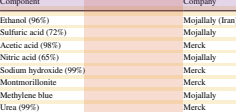

Header 2,Factor,Factor,Levels,Levels,Levels,Levels
Header 1,Complete name,Coded name,Range,−1,0,1
0,Temperature (°C),x1,25–35,25,30,35
1,pH,x2,4–8,4,6,8
2,Initial dye concen￾tration (mg L−1),x3,4–8,4,6,8
3,Mesh size,x4,50–150,50,100,150

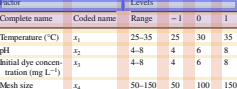

,Adsorbent,Specifc surface area (m2 g−1),Total pore vol￾ume (cm3 g−1),Average particle size (nm)
0,HCMM,25.147,8.635,84.172

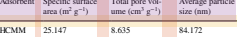

,Run,x1: T (°C),x2: pH,x3: MB initial concen￾tration (mg L−1),x4: Mesh size,MB removal (%)
0,1,25,8,4,150,84.90
1,2,30,6,6,100,89.31
2,3,30,6,4,100,90.71
3,4,30,6,6,50,91.09
4,5,30,6,6,100,89.34
5,6,25,8,8,50,87.38
6,7,30,8,6,100,92.12
7,8,30,4,6,100,87.16
8,9,35,8,4,50,92.14
9,10,35,4,8,50,85.56

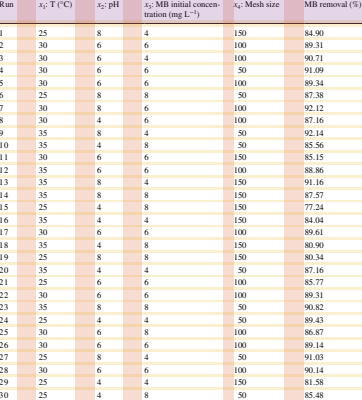

,Source,DF,Adjusted SS,Adj MS,F value,p value
0,Model,14,401.025,28.6446,218.33,0.000
1,x1,1,6.457,6.4568,49.21,0.000
2,x2,1,2.068,2.0680,15.76,0.001
3,x3,1,0.014,0.0141,0.11,0.748
4,x4,1,2.209,2.2090,16.84,0.001
5,x2 1,1,10.260,10.2603,78.20,0.000
6,x2 2,1,0.291,0.2908,2.22,0.157
7,x2 3,1,0.687,0.6872,5.24,0.037
8,x2 4,1,3.638,3.6382,27.73,0.000
9,x1x2,1,12.443,12.4433,94.84,0.000

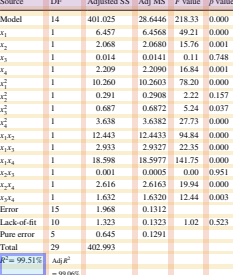

,Adsorbent(s),Adsorbent dosage (g/L),Removal percentage,Reference
0,HCMM,1,77.24–95.14,This work
1,Activated carbon from Rumex abyssinicus plant,0.2–0.6,82.16–99.96,Fito et al. (2023)
2,Barley straw and corn stalks modifed by citric acid,6–14,48–97,Soldatkina & Yanar (2023)
3,Activated carbon from Scrap Tire,2.5,89.18–90.48,Kassahun et al. (2022)
4,Barley Bran and Enset Midrib Leaf,2.5,96–98,Mekuria et al. (2022)
5,Raspberry (Rubus idaeus) leaves powder,1–5,30–44,Mosoarca et al. (2022)
6,Activated carbon from grape leaves waste,0.25–12.25,0–97.4,Mousavi et al. (2022a)
7,Activated carbon from grape wood wastes,0.25–12.25,0–95.66,Mousavi et al. (2022b)
8,Black tea wastes,13.3,30–72,Ullah et al. (2022)
9,Carboxymethyl cellulose grafted by polyacrylic acid and decorated with graphene oxide,100,38–97,Hosseini et al. (2022)

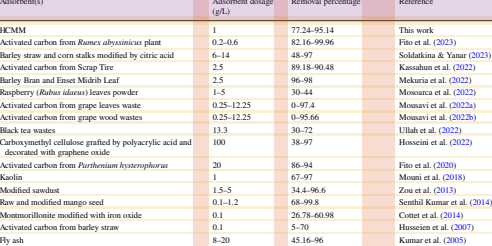

,Variable,Optimum value
0,Initial concentration of dye (mg L−1),4
1,Temperature (°C),32
2,pH,8
3,Adsorbent mesh size,70
4,Predicted removal percentage,93.91
5,Experimental removal percentage at optimal condi￾tions,95.14

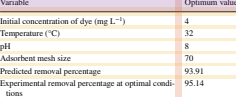

,Model,Parameters,Parameters
0,Langmuir,qm(mg g−1),159
1,Langmuir,kL(L mg−1),0.0956
2,Langmuir,R2,0.984
3,Freundlich,n,2.52
4,Freundlich,kF(mg g−1),26.42
5,Freundlich,R2,0.891
6,Temkin,B,29.245
7,Temkin,kT(L mg−1),1.518
8,Temkin,b(J g mg−1 mol−1),87
9,Temkin,R2,0.970

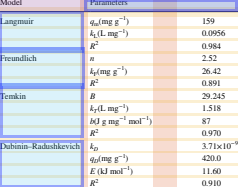

,Kinetic model,Parameters,Parameters
0,Linear driving force,k1(min−1),0.0604
1,Linear driving force,"qe,calc(mg g−1)",22.39
2,Linear driving force,"qe,exp(mg g−1)",54.28
3,Linear driving force,R2,0.927
4,Pseudo-second-order,"qe,calc(mg g−1)",55.57
5,Pseudo-second-order,k2(g.mg−1 min−1),0.018
6,Pseudo-second-order,R2,0.999
7,Intra-particle difusion,"k3,1(mg g−1 min−0.5)",1.766
8,Intra-particle difusion,I1(mg g−1),39.36
9,Intra-particle difusion,R2 1,0.992

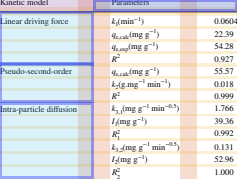

,
0,cel￾lulose nanofbril-based composites. J Colloid Interface
1,555:104–114
2,"Ludueña LN, Vecchio A, Stefani PM, Alvarez VA (2013) Extraction"
3,of cellulose nanowhiskers from natural fbers and agricultural
4,byproducts. Fibers Polym 14(7):1118–1127
5,"Macfarlane C, Warren CR, White DA, Adams MA (1999) A rapid"
6,and simple method for processing wood to crude cellulose
7,analysis of stable carbon isotopes in tree rings. Tree Physiol
8,19(12):831–835
9,"Mahmoodi NM, Hayati B, Arami M (2012) Kinetic, equilibrium"

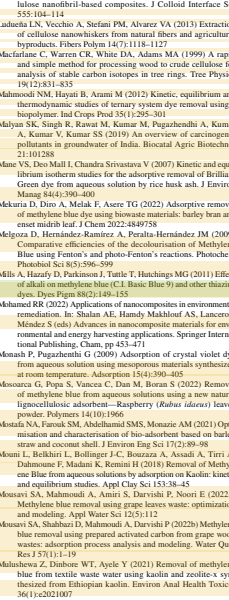

---

### ./bulk/2.pdf

,Stage of phar￾macokinetic modeling,Data utilized,Modeling activities
0,Stage 1,ManNAc single dose pharmacokinetic data (Study 12-HG￾0207),Design of structural pharmacokinetic model Explore absorption models
1,Stage 2,ManNAc BID pharmacokinetic data (Study 15-HG-0068),Covariate analysis Determination of non-linear and stationary pharmacokinetic
2,Stage 3,Stage 2 population pharmacokinetic model for ManNAc and Neu5Ac,Monte Carlo simulations of dosing regimens Recommendation for evaluation of additional TID dosing regimens in an extension of Study 15-HG-0068
3,Stage 4,"All available data, including the additional TID dosing phar￾macokinetic data generated during extension conducted in same patients from Study 15-HG-0068",Finalize pharmacokinetic model

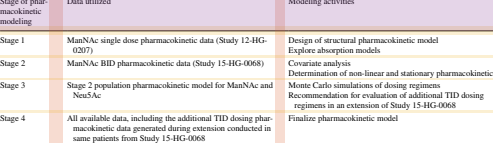

,Variable,N (%),Mean,SD,Median,Min,Max
0,Age (years),34,41.3,10.4,39.5,25,65
1,Weight (kg),34,83.5,20.2,84.6,49.3,115
2,Height (cm),34,173,13.3,172,151,197
3,BMI (kg/m2 ),34,27.6,4.7,27.2,19.1,39.8
4,BSA (m2 ),34,2.01,0.31,2.06,1.45,2.50
5,eGFR (mL/min)a,34,123,22.2,120,85.0,170
6,Albumin (g/dL),34,3.83,0.403,3.80,3.2,4.8
7,Serum creatinine (mg/dL),34,0.499,0.223,0.49,0.12,0.95
8,Creatine kinase (U/L),34,236,124,220,44.0,556
9,Sex,,,,,,

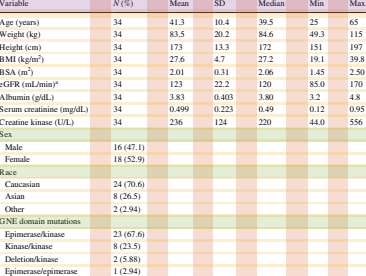

Header 2,ManNAc dose,Q8H for 30 days,Q8H for 30 days,Q12H for 30 days,Q12H for 30 days,Q24H for 30 days,Q24H for 30 days
Header 1,NaN,Median,5th–95th percentiles,Median,5th–95th percentiles,Median,5th–95th percentiles
0,Plasma ManNAc,"Css,ave (ng/mL)",,,,,
1,3 g,922,501–1550,642,359–1060,365,223–570
2,4 g,1060,573–1790,729,404–1220,411,246–650
3,6 g,1290,692–2180,881,480–1480,483,281–780
4,10 g,1650,883–2810,1120,607–1900,603,340–989
5,Plasma Neu5Ac,"Css,ave (ng/mL)",,,,,
6,3 g,633,247–2010,484,209–1420,338,174–825
7,4 g,702,265–2300,533,222–1610,364,181–921
8,6 g,818,296–2780,612,242–1930,405,190–1080

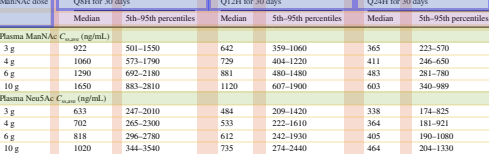

,Parameter,Final typical value estimate,%SEM
0,ka (h−1),0.256,15.2
1,CLM/F (L/h),631,14.8
2,VM/F (L),506,29.4
3,M0 (ng/mL),61.1,12.0
4,N0 (ng/mL),150,5.71
5,kout (h−1),0.283,5.65
6,SLP0 (ng/mL)−1,0.000619,29.1
7,SLPSS (ng/mL)−1,0.00334,35.0
8,kinc (h−1),0.0287,45.3
9,tlag (h),0.254,26.4

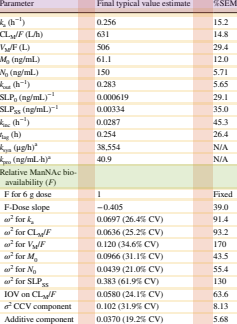

---

### ./bulk/3.pdf

Header 2,Received: 26 January 2023,"Pau Ferri1,4, Chengeng Li 1,4, Daniel Schwalbe-Koda2 , Mingrou Xie3 ,"
Header 1,Accepted: 8 May 2023,"Manuel Moliner 1 , Rafael Gómez-Bombarelli 2 , Mercedes Boronat 1 & Avelino Corma 1"
0,Check for updates,Approaching the level of molecular recognition of enzymes with solid catalysts
1,Check for updates,"is a challenging goal, achieved in this work for the competing transalkylation and disproportionation of diethylbenzene catalyzed by acid zeolites. The key"
2,Check for updates,diaryl intermediates for the two competing reactions only differ in the number
3,Check for updates,"of ethyl substituents in the aromatic rings, and therefore finding a selective"
4,Check for updates,zeolite able to recognize this subtle difference requires an accurate balance of
5,Check for updates,the stabilization of reaction intermediates and transition states inside the
6,Check for updates,zeolite microporous voids. In this work we present a computational
7,Check for updates,"metho￾dology that, by combining a fast high-throughput screeening of all zeolite"
8,Check for updates,structures able to stabilize the key intermediates with a more computationally

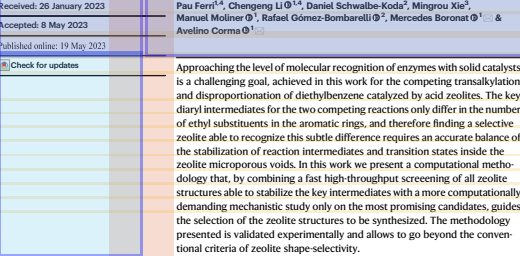

,,Channels system,n,Itrans (kJ/mol),Idisp (kJ/mol),Idisp /Itrans
0,BEA,12 × 12 × 12,3,−148,−129,0.87
1,BEC,12 × 12 × 12,1,−123,−151,1.22
2,BOG,12 × 10 × 10,4,−140,−140,1.00
3,CON,12 × 10 × 10,2,−132,−149,1.14
4,FAU,12 × 12 × 12,7,−104,−106,1.02
5,ITT,18 × 10 × 10,4,−110,−155,1.41
6,IWR,12 × 10 × 10,1,−145,−174,1.20
7,IWV,12 × 12,2,−102,−90,0.88
8,MOR,12 × 8,2,−141,−104,0.74
9,SEW,12 × 10,2,−160,−188,1.18

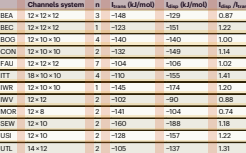

,Channels system,Channels system,Ea1,Ea2,Ea3,Ea4,Ea5,Ea6
0,transalkylation,,Ea1,Ea2,Ea3,Ea4,Ea5,Ea6
1,BEC,12 × 12 × 12,98,35,44,48,85,98
2,BOG,12 × 10 × 10,75,29,65,50,88,96
3,IWR,12 × 10 × 10,71,31,60,44,91,90
4,IWV,12 × 12,56,21,52,47,60,86
5,MOR,12 × 8,95,33,78,50,84,87
6,UTL(int),14 × 12,59,29,49,49,82,97
7,UTL(cha),14 × 12,64,28,57,45,68,80
8,disproportionation,,,,,,,
9,BEC,12 × 12 × 12,113,30,56,55,78,118

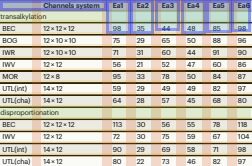

,zeolite,IZA code,DEB conv. (%),rtrans (molEB/molacidh),EB (%),TEB (%),C2H4 (%),HP (%),Eaa (kJ/mol)
0,ITQ-33,ITT,11.9,717,76.4,20.8,0.6,2.1,75.2
1,ITQ-15,UTL,17.7,1599,85.7,12.0,0,2.3,56.1
2,USY,FAU,14.7,1075,90.1,2.7,2.7,4.5,66.5
3,ITQ-17,BEC,20.8,628,88.8,8.3,0.5,2.3,59.5
4,ITQ-27,IWV,14.9,1926,94.1,0.5,2.3,3.0,58.3
5,ITQ-24,IWR,15.2,676,95.1,2.5,0.4,2.0,69.4
6,ITQ-47,BOG,14.4,349,90.4,4.4,4.8,0.4,66.2
7,mordenite,MOR,9.6,279,88.6,2.5,4.6,4.2,74.2

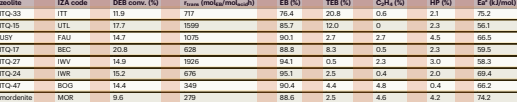

---

### ./bulk/4.pdf

,,,,,,,

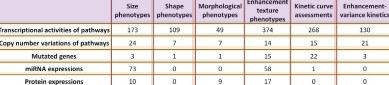

,Data Platform,Number of Features,,Number of tumors
0,Number of features and tumors in,different data platforms,,
1,Radiomics,38,,91
2,Gene expressions,20531 genes (186 pathways),,91
3,Copy number variations,19950 genes (186 pathways),,91
4,miRNA expressions,1046,,91
5,Protein expressions,142,,62
6,Mutated genes,3734,,91
7,Number of tumors with different,pathological stages,,
8,Pathological Stage,T M,N,Overall
9,0,91,46,

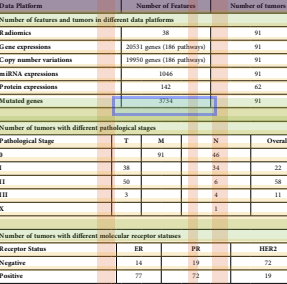

---

### ./bulk/5.pdf

,,SF-ROXOX,SF-ROXNIT,SF-ROXRED
0,No. of crystals,75,62,33
1,Images collected,1867,1257,581
2,Images merged,1377,1039,410
3,Data collection,,,
4,Space group,P213,P213,P213
5,a = b = c (A˚ ),94.95,94.92,94.61
6, =  =  ( ),90,90,90
7,Resolution (A˚ ),54.82–1.50,54.80–1.50,54.62–1.60
8,,(1.54–1.50),(1.54–1.50),(1.64–1.60)
9,Rsplit† (%),11.5 (90.4),10.6 (85.3),15.8 (70.8)

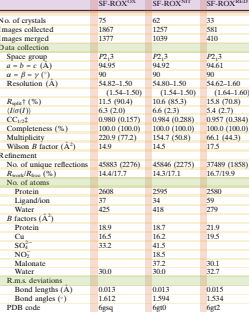

,,
0,Data collection,
1,Wavelength range (A˚ ),3.05–4.00
2,No. of images,20
3,Setting spacing (),7
4,Average exposure time (h),18
5,Space group,P213
6,a = b = c (A˚ ),97.98
7, =  =  ( ),90
8,Resolution (A˚ ),40–1.80 (1.90–1.80)
9,Rp.i.m. (%),6.3 (12.7)

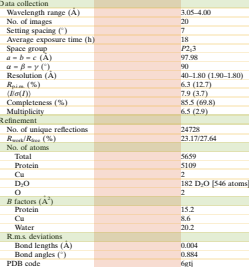

---

### ./bulk/6.pdf

,Year,Variety,Treatment,Spikelets per panicle,1000-grain weight (g),Seed setting (%) rate,Seed setting (%) rate
0,2019,CJ03,T0,267.67a,21.87c,87.67c,
1,2019,CJ03,T1,91.17b,20.10d,93.00b,
2,2019,W1844,T0,275.67a,22.91b,84.92d,
3,2019,W1844,T1,97.92b,25.95a,95.58a,
4,2020,CJ03,T0,259.75a,22.38c,92.25b,
5,2020,CJ03,T1,77.50c,20.97d,94.17a,
6,2020,W1844,T0,273.67a,24.35b,85.17c,
7,2020,W1844,T1,92.58b,25.19a,94.67a,
8,Year,Variety,Treatment,SG per panicle,IG per panicle,SG rate (%),IG rate (%)
9,2019,CJ03,T0,104.65a,163.02b,39.10a,60.90b

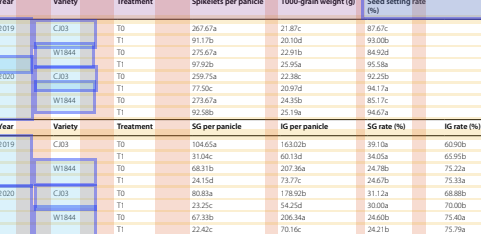

,Year,Variety,Treatment,Net photosynthetic rate (umol·m−2 s−1 ),Stomatal conductance (mmol·m−2 s−1 ),Intercellular CO2 concentration (μmol·mol−1 ),Trmmol rate (mmol·m−2 s−1 )
0,2019,CJ03,T0,22.51a,0.65b,285.30b,6.53a
1,2019,CJ03,T1,20.06c,0.52c,268.55c,5.32c
2,2019,W1844,T0,21.91a,0.74a,305.32a,6.28a
3,2019,W1844,T1,20.72b,0.60bc,274.15b,5.68b
4,2020,CJ03,T0,25.40a,0.86a,225.50ab,13.73a
5,2020,CJ03,T1,20.92c,0.54c,210.57c,11.72c
6,2020,W1844,T0,24.91a,0.89a,233.63a,13.78a
7,2020,W1844,T1,21.92b,0.75b,220.72b,12.71b

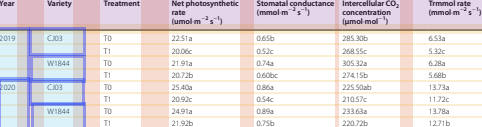

,IS,Inferior spikelets,,
0,SS,Superior spiklelets,,
1,OsSWEET11,Oryza sativa Sugar will,eventually be exported transporter,11
2,OsSUTs,Oryza sativa Sucrose transporters,,
3,SPS,Sucrose-phosphate synthase,,
4,SuSase,Sucrose synthase,,
5,AGPase,ADP-glucose pyrophosphorylase,,
6,T6P,Trehalose-6-phosphate,,
7,SnRK1,Snf1-related protein kinase-1,,
8,TPS,Trehalose-6-phosphate,synthase,
9,TPP,Trehalsoe-6-phosphate,phosphatase,

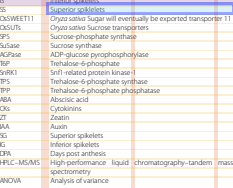

---

### ./bulk/7.pdf

Header 2,NaN,NaN,NaN,NaN,NaN,Core amino acid,Core amino acid,NaN,NaN
Header 1,Patient no,Genotype,Viral load (106 IU/ml),Sex,Age (years),70,91,rs12979860,End of treatment response a
0,R1,1a,4.36,M,52.6,R,C,CC,SVR
1,R2,1a,6.37,M,34.9,R,C,CC,SVR
2,R3,1a,7.84,M,45.8,R,C,CC,SVR
3,R4,1a,7.77,F,42.3,R,C,CC,SVR
4,R5,1a,7.05,M,45.3,R,C,CC,SVR
5,R6,1a,7.19,F,45.5,R,C,CC,SVR
6,R7,1a,5.54,F,46.9,R,C,CC,SVR
7,R8,1a,5.46,M,29.1,R,C,CT,SVR
8,R9,1a,6.18,M,50.7,R,C,CC,SVR

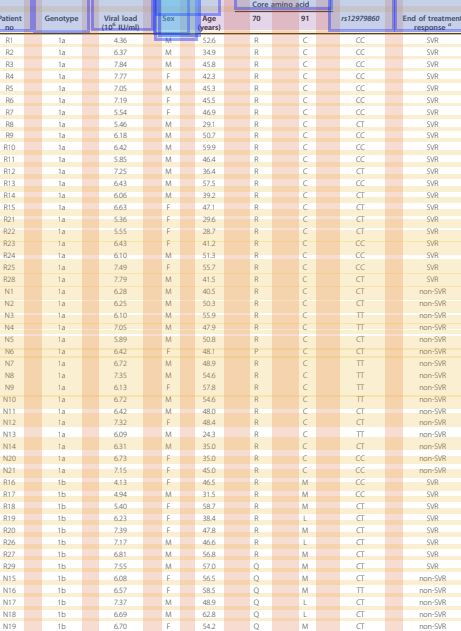

,,SVR n = 29,non-SVR n = 21,Univariate p value
0,Age (mean),45.2,48.8,0.09a
1,Number of patients < 45 / > 45 yrs,11 / 18,4 / 17,0.21b
2,Gender (m/f),17 / 12,13 / 8,1.0b
3,Baseline HCV RNA (mean log IU/mL),6.37,6.59,0.56a
4,Number with < 5.6 / > 5.6 log IU/mL,8 / 21,0 / 21,0.01b
5,Genotype 1a/1b,21 / 8,16 / 5,1.0b
6,Fibrosis (F0/F1/F2/F3/F4)c,0 / 10 / 13 / 4 / 0,2 / 4 / 4 / 7 / 2,0.19d
7,Core aa 70,28 R / 1 Q,15 R / 5 Q & 1 P,0.03b
8,Core aa 91,21 C / 6 M / 2 L,16 C / 3 M / 2 L,0.82e
9,rs12979860,16 CC / 13 CT / 0 TT,2 CC / 11 CT / 8 TT,0.0001e

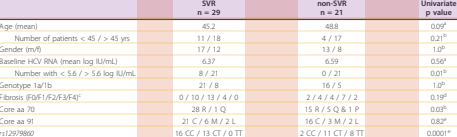

Header 2,NaN,Amino acid 70,Amino acid 70,Amino acid 70,Amino acid 70,Amino acid 91,Amino acid 91,Amino acid 91,NaN
Header 1,Genotype,Q,R,P,H,C,M,L,Total
0,1a,2%,98%,-,-,100%,-,-,920
1,1b,60%,35%,-,4%,1%,71%,28%,2022
2,2,-,100%,-,-,39%,4%,58%,83
3,3,-,93%,6%,-,99%,-,-,204
4,4,5%,95%,-,-,100%,-,-,19
5,5,86%,14%,-,-,-,-,100%,14
6,6,60%,13%,13%,15%,100%,-,-,55

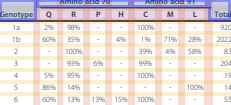

---

### ./bulk/8.pdf

,Sample,Temperature (K),Time (s),IWa,f H2 (bar),f H2O (bar),# of points,Fit 1 Absorbance,Fit 2 Absorbance,Fit 3 Absorbance,Mean ε = 6.3 m2/mol,1σ,Mean ε = 5.1 m2/mol,1σ,Corrected Mean ε = 6.3 m2/mol,Corrected ε = 5.1 m2/mol
0,,,,,,,,,,,(ppmw),,(ppmw),,(ppmw),(ppmw)
1,Per-1,2173 ± 21,30,5.97,0,0,3,0.036,0.037,0.038,35.4,2.0,43.7,3.0,2.9,3.5
2,Per-2,2166 ± 40,40,3.46,0,0,7,0.039,0.040,0.039,37.6,2.0,46.5,3.1,5.1,6.3
3,Per-3,2134 ± 29,32,3.42,1.28E-05,0.00071,7,0.053,0.054,0.050,50.0,3.2,61.8,4.6,17.5,21.7
4,Per-4,2197 ± 59,60,3.46,9.88E-07,5.74E-05,7,0.041,0.040,0.039,38.2,2.2,47.2,3.2,5.7,7.1
5,Per-5,2239 ± 25,36,3.46,5.17E-08,3.02E-06,6,0.036,0.033,0.033,32.5,2.3,40.2,3.2,0.0,0.0
6,Per-6,2151 ± 23,25,3.37,2.77E-05,0.0015,8,0.053,0.055,0.057,52.6,3.2,65.0,4.7,20.1,24.8
7,Per-7,2139 ± 13,27,3.23,8.41E-05,0.0038,7,0.069,0.070,0.072,67.2,3.8,83.1,5.6,34.7,42.9
8,Per-8,2197 ± 13,31,2.94,0.00024,0.0076,8,0.088,0.090,0.094,86.7,5.2,107.1,7.6,54.2,66.9
9,Per-9,2175 ± 15,30,2.03,0.0016,0.018,9,0.115,0.120,0.118,112.5,6.3,139.0,9.4,80.0,98.8

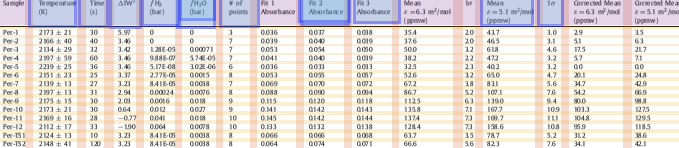

,This work 6.3 m2/mol),Peridotite,(K) 2173,(bar−0.5) 2.91 10−3,(bar) 5.7 10−5 0.027,14
0,(ε3550 = This work (ε3550 = 5.1 m2/mol),Peridotite,2173,× 3.59 × 10−3,× – 5.7 × 10−5 – 0.027,14
1,Newcombe et al. (2017),Anorthite-Diopside eutectic,1623,4.22 × 10−3,9.8 × 10−3 – 0.32,14
2,Newcombe et al. (2017),Lunar Green Glass,1623,4.04 × 10−3,9.8 × 10−3 – 0.32,11
3,Dixon et al. (1995),Mid-Ocean Ridge Basalt,1473,5.36 × 10−3,17 – 709,14
4,Hamilton and Oxtoby (1986),NaAlSi3O8,1123 – 1573,7.59 × 10−3 – 9.91 × 10−3,1685 – 2160,13

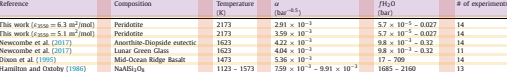

---

### ./bulk/9.pdf

Header 2,Abbreviations,NaN
Header 1,AuNP,gold nanoparticles
0,BQ,p-benzoquinone
1,BOx,bilirubin oxidase
2,CBM1,carbohydrate binding module (family 1)
3,CDH,cellobiose dehydrogenase
4,CNP,carbon nanoparticles
5,CNT,carbon nanotube
6,CV,"cyclic voltammetry, cyclic voltammogram"
7,cyt c,cytochrome c (from horse heart)
8,CYTCDH,cytochrome domain of CDH

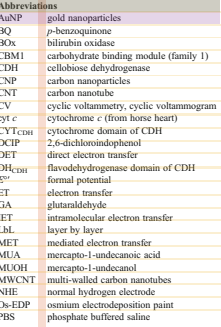

,Fungal producer of CDH,Phylum,Volumetric activity (U L−1 ),Activity assayc,Reference
0,Phanerochaete chrysosporium,B,66 (600a ),"Cellobiose, cyt c, pH 4.5","[139, 140]"
1,Pycnoporus cinnabarinus,B,355,"Cellobiose, DCIP, pH 4.5",[141]
2,Sclerotium rolfsii,B,7400 (15000b ),"Lactose, cyt c, pH 4.5","[69, 142]"
3,Trametes villosa,B,580,"Lactose, cyt c, pH 3.5",[142]
4,Trametes versicolor,B,2030,"Cellobiose, cyt c, pH 3.5",[143]
5,Ceriporiopsis subvermispora,B,170,"Lactose, DCIP, pH 6.0",[70]
6,Thielavia heterothallica,A,47,"Cellobiose, cyt c, pH 4.5","[144, 145]"
7,Corynascus thermophilus,A,4000,"Lactose, DCIP, pH 5.0",[42]
8,Neurospora crassa,A,100,"Lactose, DCIP, pH 5.5",[42]
9,Chaetomium sp. INBI 2-26(−),A,190,"Cellobiose, DCIP, pH 6.5",[146]

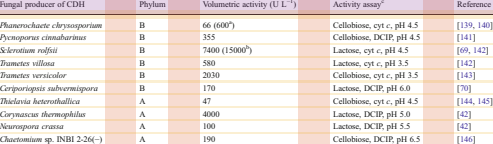

,Fungal producer of CDH,Expression host,Volumetric activity (U L−1 ),Activity assay,Reference
0,Phanerochaete chrysosporium,P. chrysospor.a,600,"Cellobiose, cyt c, pH 4.5",[77]
1,Phanerochaete chrysosporium,P. pastoris,1800,"Cellobiose, cyt c, pH 4.5",[78]
2,P. chrysosporium DHCDH,E. coli,733b,"Cellobiose, DCIP, pH 5.0",[81]
3,Pycnoporus cinnabarinus,P. pastoris,7800,"Cellobiose, DCIP, pH 5.0",[147]
4,Trametes versicolor,P. pastoris,5218,"Cellobiose, cyt c, pH 4.2",[148]
5,Myriococcum thermophilum,P. pastoris,2150,"Lactose, DCIP, pH 5.0",[82]
6,Neurospora crassa (CDH IIA),P. pastoris,1700,"Lactose, DCIP, pH 5.0",[62]
7,Neurospora crassa (CDH IIB),P. pastoris,410,"Lactose, DCIP, pH 5.0",[62]
8,Corynascus thermophilus,P. pastoris,376,"Lactose, DCIP, pH 5.5",[75]
9,Thielavia terrestris,A. oryzae,NG,"Cellobiose, DCIP, pH 6.0",[79]

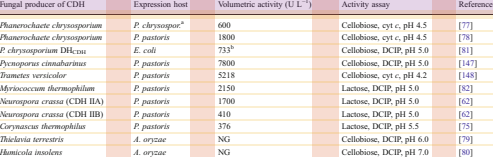

,Electrode nanomodification,Modification method,ET,Surface modification,Surface functionality,Measurement method,pH and substrate concentration,Current density (μAcm−2),Reference
0,GC+SWCNTs; PsCDH,Drop-casting,DET,p-Phenylenediamine,NH2,CV; 1 mV s−1,"3.5, 5 mM lactose",500,[47]
1,GC+SWCNTs; PsCDH,Drop-casting,DET,p-Aminobenzoic acid,COOH,CV; 1 mV s−1,"4.5, 5 mM lactose",150,[47]
2,Au+AuNP; PcCDH,Drop-casting,DET,ATP/MP+GA,OH,CV; 2 mV s−1,"4.5, 10 mM lactose",4.0,[48]
3,Au+AuNP; PcCDH,Drop-casting,DET,ATP/MBA+GA,COOH,CV; 2 mV s−1,"4.5, 10 mM lactose",29.3,[48]
4,Au+AuNP; PcCDH,Drop-casting,DET,MUNH2/MUOH+GA,OH,CV; 2 mV s−1,"4.5, 10 mM lactose",11.6,[48]
5,Au+AuNP; PcCDH,Drop-casting,DET,MUNH2/MUA+GA,COOH,CV; 2 mV s−1,"4.5, 10 mM lactose",15.2,[48]
6,SPCE+MWCNT; TvCDH,Drop-casting,DET,COOH-functionalised MWCNT,COOH,FIA,"4.5, 0.1 mM lactose",0.08,[55]
7,SPCE+MWCNT; PsCDH,Drop-casting,DET,COOH-functionalised MWCNT,COOH,FIA,"4.5, 10 mM lactose",0.5,[55]
8,SPCE+MWCNT; PsCDH,Drop-casting,DET,COOH-functionalised MWCNT and GA or PEDGDE,COOH,FIA,"4.5, 10 mM lactose",5.6,[55]
9,GE+CNP; CsCDH,Drop-casting,DET,None,Not studied,CV; 2 mV s−1,"4.5, 50 mM lactose",297 deglycosylated enzyme ; 240 glycosylated enzyme,[94]

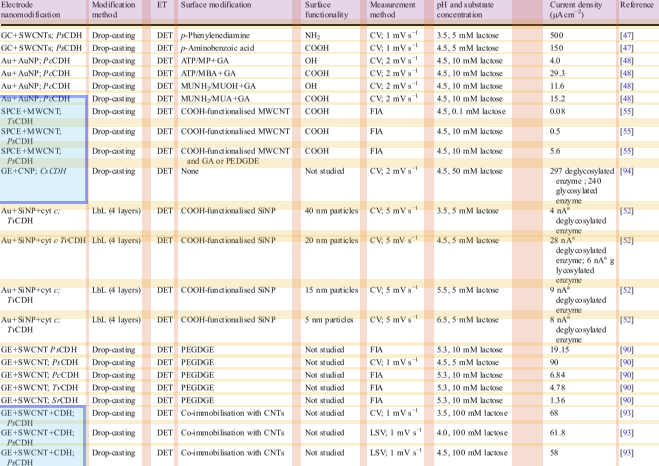

,Electrode nanomodification,Modification method,ET,Surface modification,Surface functionality,Measurement method,pH and substrate concentration,Current density (μAcm−2 ),Reference
0,GE+SWCNT+CDH; PsCDH,Drop-casting,DET,Co-immobilisation with CNTs,Not studied,LSV; 1 mV s−1,"5.0, 100 mM lactose",45,[93]
1,GE+SWCNT+CDH; PsCDH,Drop-casting,DET,Co-immobilisation with CNTs,Not studied,LSV; 1 mV s−1,"5.5, 100 mM lactose",30,[93]
2,GE+SWCNT+CDH; PsCDH,Drop-casting,DET,Co-immobilisation with CNTs,Not studied,LSV; 1 mV s−1,"6.0, 100 mM lactose",13,[93]
3,GE+SWCNT+CDH; PsCDH,Drop-casting,MET,Co-immobilisation with CNTs+ PEGDGE,Not studied,LSV; 0.2 mV s−1,"3.5, 100 mM lactose",300,[93]
4,GE+SWCNT+CDH; PsCDH,Drop-casting,MET,Co-immobilisation with CNTs+ PEGDGE,Not studied,LSV; 0.2 mV s−1,"4.0, 100 mM lactose",500,[93]
5,GE+SWCNT+CDH; PsCDH,Drop-casting,MET,Co-immobilisation with CNTs+ PEGDGE,Not studied,LSV; 0.2 mV s−1,"4.5, 100 mM lactose",650,[93]
6,GE+SWCNT+CDH; PsCDH,Drop-casting,MET,Co-immobilisation with CNTs+ PEGDGE,Not studied,LSV; 0.2 mV s−1,"5.0, 100 mM lactose",700,[93]
7,GE+SWCNT+CDH; PsCDH,Drop-casting,MET,Co-immobilisation with CNTs+ PEGDGE,Not studied,LSV; 0.2 mV s−1,"6.0, 100 mM lactose",700,[93]
8,Au+AuNP; CtCDH,Drop-casting,DET,ATP/MBA+GA,OH,LSV; 2 mV s−1,"7.4, 5 mM lactose; 100 mM glucose",40; 26,[49]
9,Au+AuNP; CtCDH,Drop-casting,DET,ATP/MBA+GA,OH,LSV 2 mV s−1,"7.4, 5 mM glucose",7.5,[51]

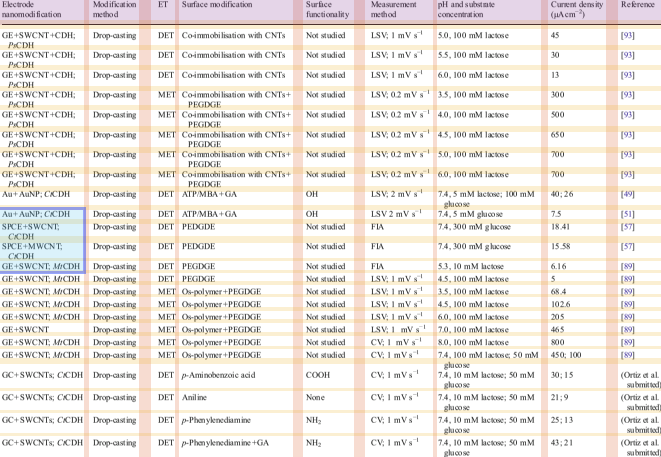

,Electrode nanomodification,Modification method,ET,Surface modification,Surface functionality,Measurement method,pH and substrate concentration,Current density (μAcm−2),Reference
0,GC+SWCNTs; CtCDH,Drop-casting,DET,"N,N-Diethyl-p-phenylenediamine","N-(N,N)-Diethyl",CV; 1 mV s−1,"7.4, 10 mM lactose; 50 mM glucose",16; 8,(Ortiz et al. submitted)
1,GC+SWCNTs; CtCDH,Drop-casting,DET,p-Aminophenol,OH,CV; 1 mV s−1,"7.4, 10 mM lactose; 50 mM glucose",23; 14,(Ortiz et al. submitted)
2,GC+SWCNTs; CtCDH,Drop-casting,DET,Not used,Not studied,CV; 1 mV s−1,"7.4, 10 mM lactose; 50 mM",8; 4,(Ortiz et al.

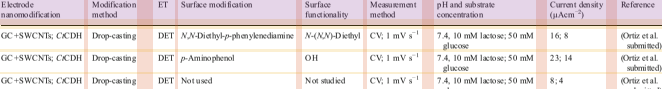

Header 2,Mixed SAMs,NaN,AuNPs,AuNPs,AuNPs,AuNPs,NaN
Header 1,NaN,Polycrystalline gold \nJ (μA cm−2 ),J (μA cm−2 ),E°′ (mV),ΔE (mV),ks (s−1 ),SPR \nΓ (pmol mm−2 )
0,4-ATP/4-MP,0.26,4.0,161.7,14.7,59.8,5.79
1,4-ATP/4-MBA,0.40,29.3,161.5,14.6,52.1,5.71
2,MUNH2/MUOH,0.34,11.6,161.8,14.7,154.0,5.67
3,MUNH2/MUA,0.49,15.2,161.3,14.6,112.0,5.65

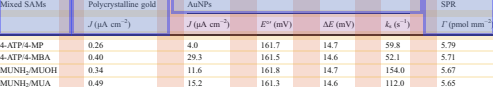

,Analyte,Detection limit,Sensitivity (μA mM−1 cm−2 ),Mediator/ enhancera,Electrode modification,Electrode material,CDH,Reference
0,Noradrenaline,1 nM,"15,800",Cellobiose,Adsorption,SG,PcCDH,[85]
1,Catechol,1 nM,"9,500",Cellobiose,Adsorption,SG,PcCDH,[85]
2,Hydroquinone,0.75 nM,"11,140",Cellobiose,Adsorption,SG,PcCDH,[85]
3,L-Adrenaline,5 nM,"1,140",Cellobiose,Adsorption,SG,PcCDH,[85]
4,3-Hydroxylamine hydrochloride,2.5 nM,"9,160",Cellobiose,Adsorption,SG,PcCDH,[85]
5,"3,4-Hydroxyphenylacetic acid",1 nM,"13,440",Cellobiose,Adsorption,SG,PcCDH,[85]
6,Lactose,1 μM,17.8,No,Adsorption,SG,TvCDH,[85]
7,Lactose,1 μM,11.0,No,Adsorption,SG,PsCDH,[85]
8,Lactose,1 μM,1.06,No,Adsorption,SG,MtCDH,[88]
9,Lactose,1 μM,2.8,No,Adsorption,SCE,MtCDH,[149]

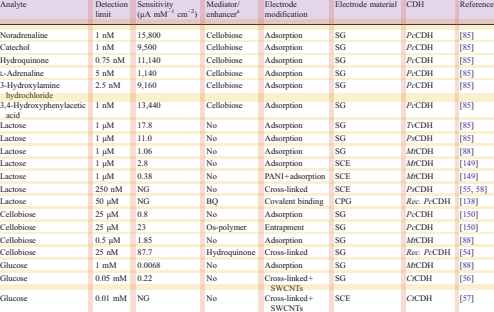

,,
0,,(2012) Bioelectrochemistry. doi:10.1016/j.bioelechem.2012.05.004
1,18.,"Kostesha NV, Almeida JRM, Heiskanen AR, Gorwa-Grauslund Emnéus J Anal Chem 81"
2,,"MF, Hahn-Hägerdahl B, (2009) (24):9896–9901"
3,19.,"Ludwig R, Harreither W, Tasca F, Gorton L (2010) Chem Phys Chem 11(13):2674–2697"
4,20.,"Patil SA, Hasan K, Leech D, Hägerhäll C, Gorton L (2012) Chem"
5,21.,"Commun 48(82):10183–10185 Rawson FJ, Garrett DJ, Leech D, Downard AJ, Baronian KHR"
6,22.,"(2011) Biosens Bioelectron 26(5):2383–2389 Rawson FJ, Gross AJ, Garrett DJ, Downard AJ, Baronian KHR"
7,,(2012) Electrochem Commun 15(1):85–87
8,23. 24.,"Katz E, Willner I (2004) Chem Phys Chem 5(8):1085–1104 Meredith MT, Minteer SD (2012) Annu Rev Anal Chem 5"
9,,(1):157–179

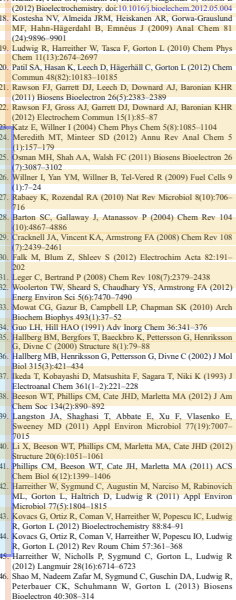

In [45]:
from IPython.display import display, Markdown
import pandas as pd

prev_doc = None
for df, img, ft in zip(dfs, images, results):
    with pd.option_context('display.max_rows', 500, "display.multi_sparse", False):
        if ft.page.filename != prev_doc:
            prev_doc = ft.page.filename
            display(Markdown('---'))
            display(Markdown(f'### {ft.page.filename}'))
            
        if df is not None:
            html = df.fillna("").to_html()
        else:
            html = "Failed to extract table"
        display_html_and_image(html, img)
        


The bulk pdfs are the same as mentioned in the quickstart notebooks. Please see this table for attribution.

| doi                                  | Title                                                                                                                                                     | Author        | Notes                                           | Url                                                                       | License                                                     |
|--------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|---------------|-------------------------------------------------|---------------------------------------------------------------------------|-------------------------------------------------------------|
| 10.1007/s13201-023-02046-6           | Synthesis of a nanocomposite with holocellulose extracted from barley straw and montmorillonite, and optimization of the removal of methylene blue dye using the synthesized adsorbent | Farzi et al.  |                                                 | [Link](https://link.springer.com/content/pdf/10.1007/s13201-023-02046-6.pdf)  | CC BY 4.0   |
| 10.1007/s40268-021-00343-6           | Population Pharmacokinetic Model of N-acetylmannosamine (ManNAc) and N-acetylneuraminic acid (Neu5Ac) in Subjects with GNE Myopathy                          | Wart et al.   |                                                 | [Link](https://link.springer.com/content/pdf/10.1007/s40268-021-00343-6.pdf)  | CC BY 4.0   |
| 10.1038/s41467-023-38544-z           | Approaching enzymatic catalysis with zeolites or how to select one reaction mechanism competing with others                                                | Ferri et al.  | alternating table style                        | [Link](https://www.nature.com/articles/s41467-023-38544-z.pdf)               | CC BY 4.0   |
| 10.1038/srep17787                    | Deciphering Genomic Underpinnings of Quantitative MRI-based Radiomic Phenotypes of Invasive Breast Carcinoma                                               | Zhu et al.    | image table and difficult table with uneven columns | [Link](https://www.nature.com/articles/srep17787.pdf)                        | CC BY 4.0   |
| 10.1107/s2052252519008285            | Catalytically important damage-free structures of a copper nitrite reductase obtained by femtosecond X-ray laser and room-temperature neutron crystallography | Halsted et al. |                                                 | [Link](https://journals.iucr.org/m/issues/2019/04/00/ec5013/ec5013.pdf)      | CC BY 4.0                                                   |
| 10.1186/s12284-023-00656-x           | The Inferior Grain Filling Initiation Promotes the Source Strength of Rice Leaves                                                                          | Jiang et al.  |                                                 | [Link](https://thericejournal.springeropen.com/counter/pdf/10.1186/s12284-023-00656-x.pdf) | CC BY 4.0   |
| 10.1186/1471-2334-11-124             | Core mutations, IL28B polymorphisms and response to peginterferon/ribavirin treatment in Swedish patients with hepatitis C virus genotype 1 infection      | Alestig et al.| very large table                                | [Link](https://bmcinfectdis.biomedcentral.com/counter/pdf/10.1186/1471-2334-11-124.pdf)    | CC BY 2.0                                                   |
| 10.48550/arXiv.2211.13344            | Solubility of water in peridotite liquids and the prevalence of steam atmospheres on rocky planets                                                         | Sossi et al.  | vertical table                                  | [Link](https://arxiv.org/pdf/2211.13344)                                        | CC BY 4.0   |
| 10.1007/s00216-012-6627-x | Cellobiose dehydrogenase modified electrodes: advances by materials science and biochemical engineering | Ludwig et al. | vertical tables, many tables | [Link](https://link.springer.com/content/pdf/10.1007/s00216-012-6627-x.pdf) | CC BY |
